In [1]:
import sys, joblib
from utils import *
from single_var_model import SK_model
import sklearn
import random
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")


### Relevant functions

In [2]:
def load_MPOG_test_data(test_data):
    
#     if primary_cpt == True:
#         test_data = pd.read_csv('c2_match.csv').dropna(subset = ['NOTHBLEED']).reset_index(drop = True)
#     else:
#         test_data = pd.read_csv('c2_pred_match.csv').dropna(subset = ['NOTHBLEED']).reset_index(drop = True)

    test_data.loc[test_data.SEX == 'Male', 'SEX'] = 1
    test_data.loc[test_data.SEX == 'Female', 'SEX'] = 0

    pr_cols = ['PRSODM', 'PRCREAT', 'PRALBUM', 'PRBILI', 'PRHCT', 'PRPLATE', 'PRPTT', 'PRINR']
    como_cols = ['DIABETES', 'HXCOPD', 'HXCHF', 'HYPERMED']

    for col in pr_cols:
        test_data[col].replace(to_replace=-999, value=np.nan, inplace=True)

    for col in como_cols:
        test_data[col].replace(to_replace='Yes', value=1, inplace=True)
        test_data[col].replace(to_replace='No', value=0, inplace=True)
        test_data[col].replace(to_replace='Missing', value=np.nan, inplace=True)

    return test_data

#-------------------------------------------------

def load_model_pipeline(model_path, test_data, perform_impute = True):

    data_pipeline = joblib.load(model_path)

    #model, X_test, y_test, new_threshold = run_model(data_pipeline, data_source, prefilter = 0)

    # define parameters
    use_static = data_pipeline.use_static
    perform_impute = data_pipeline.perform_impute
    use_words = data_pipeline.use_words
    best_threshold = data_pipeline.best_threshold
    feat_used = data_pipeline.feat_used
    model = data_pipeline.model

    y_test = test_data.NOTHBLEED
    test_static = test_data[feat_used]
    #test_text = test_data['CPT_PRIMARY']

    # transform data
    #perform_impute = True
    if perform_impute:
        test_static, _ = perform_imputation(test_static, imputer=data_pipeline.imputer)
        data_imputed = test_static
    else:
        data_imputed = test_static

    X_test = data_pipeline.normalizer.transform(data_imputed)

    return data_pipeline, X_test, y_test, feat_used

#------------------------------------------------------------

def evaluate_model(model, X_test, y_test, save_path, plot = True):
    
    #print('eval w re-tuned threshold for sens 0.96')

    # Testing
    y_prob = model.predict_proba(X_test)[:, 1]

    # Evaluation
    fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
    prec, rec, _ = metrics.precision_recall_curve(y_test, y_prob)


    def line_search_best_metric(y_test, y_prob, sens_thresh=0.96):
        for t in np.arange(0.0, 1.0, 0.0001):
            sens, spec, PPV, NPV, acc = metric_eval(y_test, y_prob > t)
            if sens < sens_thresh:
                return (sens, spec, PPV, NPV, acc), t


    (sensitivity, specificity, PPV, NPV, frac_pos), best_threshold = line_search_best_metric(y_test, y_prob)

    y_pred = y_prob > best_threshold

    auroc = metrics.auc(fpr, tpr)
    auprc = metrics.auc(rec, prec)

#     print('--------------------------------------------')
#     print('Evaluation of test set:')
#     print("AU-ROC:", "%0.4f" % metrics.auc(fpr, tpr), "AU-PRC:", "%0.4f" % metrics.auc(rec, prec))
#     print("sensitivity:", "%0.4f" % sensitivity,
#           "specificity:", "%0.4f" % specificity,
#           "PPV:", "%0.4f" % PPV,
#           "NPV:", "%0.4f" % NPV,
#           "fraction pos:", "%0.4f" % frac_pos)
#     print(metrics.confusion_matrix(y_test, y_pred))
#     print('--------------------------------------------')

    if plot == True:
        
        # plot and save figs
        fig, ax = plt.subplots(1, 3, figsize = (15, 4))
        ax[0].plot(fpr, tpr); ax[0].set_title('AUROC')
        ax[1].plot(rec, prec); ax[1].set_title('AUPRC')
        fraction_pos, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=20)
        ax[2].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        ax[2].plot(mean_predicted_value, fraction_pos, 's-')
        ax[2].set_xlabel('mean predicted value'); ax[2].set_ylabel('fraction positive')
        plt.savefig('result/AUC_plot.svg')
        fig.suptitle('Peformance metrics for {}'.format(model_path))
        plt.savefig(os.path.join(save_path, 'AUC_AUPRC.svg'))

    #print('New re-tuned MPOG_caseinfo2_threshold', best_threshold)
    
    return auroc, auprc, sensitivity, specificity, PPV, NPV, frac_pos, best_threshold

#-------------------------------------------------------------------------

def bootstrap_stats(model, X_test, y_test, save_path, best_threshold = None, data_size =100000):
    y_test = np.array(y_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    observed_result = pd.Series(calculate_metrics(y_test, y_prob, best_threshold),
        index = ['AUROC', 'AUPRC', 'Sensitivity', 'Specificity', 'PPV', 'FractionPos', 'Brier'], name='Observed')
    boot_results = []
    # run bootstrapping
    for i in range(1000):
        rand_i = [random.randint(0, len(y_prob)-1) for i in range(data_size)]
        y_prob_r = y_prob[rand_i]
        y_test_r = y_test[rand_i]
        boot_results.append(calculate_metrics(y_test_r, y_prob_r, best_threshold))

    # summarize results
    boot_results = pd.DataFrame(boot_results,
        columns = ['AUROC', 'AUPRC', 'Sensitivity', 'Specificity', 'PPV', 'FractionPos', 'Brier'])
    
    boot_results_df = pd.concat([observed_result, boot_results.quantile(0.025), boot_results.quantile(0.975)], axis=1)
    boot_results_df.to_csv(os.path.join(save_path, "bootstrap_results.csv"), index=True)
    
    return boot_results_df
#---------------------------------------------------------

def plot_auc(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
    prec, rec, _ = metrics.precision_recall_curve(y_test, y_prob)
    obs_pos, pred_pos = calibration_curve(y_test, y_prob, n_bins=20)
    return fpr, tpr, prec, rec, obs_pos, pred_pos

#-----------------------------------------------------------


### Function to estimate institution-specific results for cpt-pred/cpt-prim and XGB/baseline

In [3]:
def inst_specific_results(model_path, cpt_pred = True):
    
    if cpt_pred == True:
        test_data = pd.read_csv('c2_pred_match.csv').dropna(subset = ['NOTHBLEED']).reset_index(drop = True)
    else:
        test_data = pd.read_csv('c2_match.csv').dropna(subset = ['NOTHBLEED']).reset_index(drop = True)

    test_data = load_MPOG_test_data(test_data)
    assert test_data.CaseID.nunique() == len(test_data)

    bad_inst_list = [67, 118, 92, 101, 91, 115, 102, 99, 13, 98]
    test_data = test_data.loc[~test_data.Institution.isin(bad_inst_list)].reset_index(drop = True)

    inst_names = test_data.Institution.unique()
    print('Total number of institutions selected = {}'.format(len(inst_names)))
    root_dir = 'S:\PCRC 186 Lou\Sayantan\MPOG_work'

    metric_list = ['institution', 'auroc', 'auprc', 'sensitivity', 'specificity', 'PPV', 'NPV', 'frac_pos', 'best_threshold', 'num_cases', 'nonzero_per_tf']
    other_info_cols = ['med_school_affiliation', 'hospital_bed_size', 'frac_nothbleed', 'frac_mortality', 'mean_base_units', 'frac_base_units_gt7', 'frac_asa_gt2', 'frac_per_tf_gt1', 'frac_tran01', 'frac_tran02']

    results_all_df_xgb = pd.DataFrame(columns = metric_list + other_info_cols)
    cal_results = pd.DataFrame(columns = ['Institution', 'Bin', 'pred_true', 'pred_prob'])

    allinst_cal_results = []
    #bad_cpt_list = []
    #null_pt_list = []

    #----------------------------------------------------

    plt.figure(figsize = (12,12))
    
    inst_data_dict = {}
    for name in inst_names:

        inst_test_data = test_data.loc[test_data.Institution == name].reset_index(drop = True)
        num_cases = len(inst_test_data)
        print('Number of cases from {} = {}'.format(name, len(inst_test_data)))

        inst_test_data = inst_test_data.dropna(subset = 'percent_transfused').reset_index(drop = True)
        nonnull_pt = len(inst_test_data)
        print('Number of cases from {} with not null percent_transfused = {}'.format(name, nonnull_pt))

        if nonnull_pt == 0:
            null_pt_list.append(name)
            print('No non-null values for institution {}'.format(name))
            print('--------------------------------\n')
            print('--------------------------------')
            continue

        #-------- Collecting non-modeling info for each institution-----------------

        try:

            med_school_affiliation = inst_test_data['Medical School Affiliation'].unique()
            hospital_bed_size = inst_test_data['Hospital Bed Size'].unique()
            frac_nothbleed = inst_test_data['NOTHBLEED'].sum()/len(inst_test_data)
            frac_mortality = len(inst_test_data.loc[inst_test_data['Mortality (In Hospital 30-day)']=='Yes'])/num_cases
            mean_base_units = inst_test_data['Anesthesia CPT - Base Unit Value'].mean()
            frac_base_units_gt7 = len(inst_test_data.loc[inst_test_data['Anesthesia CPT - Base Unit Value'] > 7])/num_cases
            frac_asa_gt2 = len(inst_test_data.loc[inst_test_data['ASA Class'].isin(['ASA Class 3', 'ASA Class 4', 'ASA Class 5'])])/num_cases
            frac_per_tf_gt1 = len(inst_test_data.loc[inst_test_data['percent_transfused'] > 1])/num_cases
            frac_tran01 = len(inst_test_data.loc[inst_test_data['TRAN-01'] == 'Passed'])/len(inst_test_data.loc[inst_test_data['TRAN-01'].isin(['Passed', 'Failed'])])
            frac_tran02 = len(inst_test_data.loc[inst_test_data['TRAN-02'] == 'Passed'])/len(inst_test_data.loc[inst_test_data['TRAN-02'].isin(['Passed', 'Failed'])])

            print('Medical School Affiliation : {}'.format(med_school_affiliation))
            print('Hospital bed size : {}'.format(hospital_bed_size))
            print('Fraction with NOTHBLEED == 1 : {}'.format(frac_nothbleed))     
            print('Fraction with mortality == 1 : {}'.format(frac_mortality))      
            print('Mean base units : {}'.format(mean_base_units))
            print('Fraction with base units > 7 : {}'.format(frac_base_units_gt7))
            print('Fraction with ASA Class > 2 : {}'.format(frac_asa_gt2))      
            print('Fraction with percent_transfused > 1 : {}'.format(frac_per_tf_gt1))
            print('Fraction with QM measure TRAN-01 == Passed : {}'.format(frac_tran01)) # Passed/Passed + Failed
            print('Fraction with QM measure TRAN-02 == Passed : {}'.format(frac_tran02)) 

        except ZeroDivisionError:
            print("Encountered a ZeroDivisionError. Skipping the iteration.")

        inst_data_dict[name] = inst_test_data

        data_pipeline, X_test, y_test, feat_used = load_model_pipeline(model_path, inst_test_data)
        
        save_path = 'S:\PCRC 186 Lou\Sayantan\MPOG_work'
        auroc, auprc, sensitivity, specificity, PPV, NPV, frac_pos, best_threshold = evaluate_model(data_pipeline.model, X_test, y_test, save_path, plot = False)
        print('AUROC = {}, AUPRC = {}, Sensitivity = {}'.format(auroc, auprc, sensitivity))

        #col_list = [name, auroc, auprc, sensitivity, specificity, PPV, NPV, frac_pos, best_threshold, num_cases, nonnull_pt]

        col_list = [name, auroc, auprc, sensitivity, specificity, PPV, NPV, frac_pos, best_threshold, 
                        num_cases, nonnull_pt, med_school_affiliation, hospital_bed_size, frac_nothbleed,
                        frac_mortality, mean_base_units, frac_base_units_gt7, frac_asa_gt2, frac_per_tf_gt1, frac_tran01, frac_tran02]

        if sensitivity == 0:
            bad_cpt_list.append(name)

        results_all_df_xgb = results_all_df_xgb.append(pd.Series(col_list, index = results_all_df_xgb.columns), ignore_index = True)

        ############# Plot the calibration curve ############
        #print(name)
        y_pred_prob = data_pipeline.model.predict_proba(X_test)[:, 1]
        prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=20)
        
        inst_cal_results = pd.DataFrame({'Bin ID': np.arange(len(prob_true)),
                                         'True Probability': prob_true, 
                                         'Predicted Probability': prob_pred})
        inst_cal_results['Institution'] = name
        allinst_cal_results.append(inst_cal_results)

        
        plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='blue', label='Calibration Curve', alpha = 0.2)

        #bs_results = bootstrap_stats(data_pipeline.model, X_test, y_test, save_path, best_threshold = None, data_size =100000)
        print('--------------------------------\n')
        print('--------------------------------')
     
    cal_results = pd.concat(allinst_cal_results, ignore_index=True)
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    #plt.legend(fontsize = 24)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlabel('Mean Predicted Probability', fontsize = 24)
    plt.ylabel('Fraction of Positives', fontsize = 24)
    plt.title('Calibration Plot'.format(name), fontsize = 28)
    plt.grid(True)
    #plt.tight_layout()
    #plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
    
    #plt.savefig(os.path.join(root_dir,'calibration_inst.pdf'),bbox_inches='tight', dpi=600)
    
    return results_all_df_xgb, cal_results


In [4]:
def inst_specific_results_bs(model_path, cpt_pred = True):
    
    if cpt_pred == True:
        test_data = pd.read_csv('c2_pred_match.csv').dropna(subset = ['NOTHBLEED']).reset_index(drop = True)
    else:
        test_data = pd.read_csv('c2_match.csv').dropna(subset = ['NOTHBLEED']).reset_index(drop = True)

    test_data = load_MPOG_test_data(test_data)
    assert test_data.CaseID.nunique() == len(test_data)

    bad_inst_list = [67, 118, 92, 101, 91, 115, 102, 99, 13, 98]
    test_data = test_data.loc[~test_data.Institution.isin(bad_inst_list)].reset_index(drop = True)

    inst_names = test_data.Institution.unique()
    print('Total number of institutions selected = {}'.format(len(inst_names)))
    root_dir = 'S:\PCRC 186 Lou\Sayantan\MPOG_work'

    metric_list = ['institution', 'auroc', 'auprc', 'sensitivity', 'specificity', 'PPV', 'NPV', 'frac_pos', 'best_threshold', 'num_cases', 'nonzero_per_tf']
    other_info_cols = ['med_school_affiliation', 'hospital_bed_size', 'frac_nothbleed', 'frac_mortality', 'mean_base_units', 'frac_base_units_gt7', 'frac_asa_gt2', 'frac_per_tf_gt1', 'frac_tran01', 'frac_tran02']

    results_all_df_xgb = pd.DataFrame(columns = metric_list + other_info_cols)
    cal_results = pd.DataFrame(columns = ['Institution', 'Bin', 'pred_true', 'pred_prob'])

    allinst_cal_results = []
    #bad_cpt_list = []
    #null_pt_list = []

    #----------------------------------------------------

    plt.figure(figsize = (12,12))
    
    inst_data_dict = {}
    for name in inst_names:

        inst_test_data = test_data.loc[test_data.Institution == name].reset_index(drop = True)
        num_cases = len(inst_test_data)
        print('Number of cases from {} = {}'.format(name, len(inst_test_data)))

        inst_test_data = inst_test_data.dropna(subset = 'percent_transfused').reset_index(drop = True)
        nonnull_pt = len(inst_test_data)
        print('Number of cases from {} with not null percent_transfused = {}'.format(name, nonnull_pt))

        if nonnull_pt == 0:
            null_pt_list.append(name)
            print('No non-null values for institution {}'.format(name))
            print('--------------------------------\n')
            print('--------------------------------')
            continue

        #-------- Collecting non-modeling info for each institution-----------------

        try:

            med_school_affiliation = inst_test_data['Medical School Affiliation'].unique()
            hospital_bed_size = inst_test_data['Hospital Bed Size'].unique()
            frac_nothbleed = inst_test_data['NOTHBLEED'].sum()/len(inst_test_data)
            frac_mortality = len(inst_test_data.loc[inst_test_data['Mortality (In Hospital 30-day)']=='Yes'])/num_cases
            mean_base_units = inst_test_data['Anesthesia CPT - Base Unit Value'].mean()
            frac_base_units_gt7 = len(inst_test_data.loc[inst_test_data['Anesthesia CPT - Base Unit Value'] > 7])/num_cases
            frac_asa_gt2 = len(inst_test_data.loc[inst_test_data['ASA Class'].isin(['ASA Class 3', 'ASA Class 4', 'ASA Class 5'])])/num_cases
            frac_per_tf_gt1 = len(inst_test_data.loc[inst_test_data['percent_transfused'] > 1])/num_cases
            frac_tran01 = len(inst_test_data.loc[inst_test_data['TRAN-01'] == 'Passed'])/len(inst_test_data.loc[inst_test_data['TRAN-01'].isin(['Passed', 'Failed'])])
            frac_tran02 = len(inst_test_data.loc[inst_test_data['TRAN-02'] == 'Passed'])/len(inst_test_data.loc[inst_test_data['TRAN-02'].isin(['Passed', 'Failed'])])

            print('Medical School Affiliation : {}'.format(med_school_affiliation))
            print('Hospital bed size : {}'.format(hospital_bed_size))
            print('Fraction with NOTHBLEED == 1 : {}'.format(frac_nothbleed))     
            print('Fraction with mortality == 1 : {}'.format(frac_mortality))      
            print('Mean base units : {}'.format(mean_base_units))
            print('Fraction with base units > 7 : {}'.format(frac_base_units_gt7))
            print('Fraction with ASA Class > 2 : {}'.format(frac_asa_gt2))      
            print('Fraction with percent_transfused > 1 : {}'.format(frac_per_tf_gt1))
            print('Fraction with QM measure TRAN-01 == Passed : {}'.format(frac_tran01)) # Passed/Passed + Failed
            print('Fraction with QM measure TRAN-02 == Passed : {}'.format(frac_tran02)) 

        except ZeroDivisionError:
            print("Encountered a ZeroDivisionError. Skipping the iteration.")

        inst_data_dict[name] = inst_test_data

        data_pipeline, X_test, y_test, feat_used = load_model_pipeline(model_path, inst_test_data)
        
        if inst_test_data.percent_transfused.sum() == 0:
            print('All percent transfused values == 0 for institution {}'.format(name))
            print('--------------------------------\n')
            print('--------------------------------')
            continue
        
        save_path = 'S:\PCRC 186 Lou\Sayantan\MPOG_work'
        
        try:
            
            auroc, auprc, sensitivity, specificity, PPV, NPV, frac_pos, best_threshold = evaluate_model(data_pipeline.model, X_test, y_test, save_path, plot = False)
            print('AUROC = {}, AUPRC = {}, Sensitivity = {}'.format(auroc, auprc, sensitivity))

            #col_list = [name, auroc, auprc, sensitivity, specificity, PPV, NPV, frac_pos, best_threshold, num_cases, nonnull_pt]

            col_list = [name, auroc, auprc, sensitivity, specificity, PPV, NPV, frac_pos, best_threshold, 
                        num_cases, nonnull_pt, med_school_affiliation, hospital_bed_size, frac_nothbleed,
                        frac_mortality, mean_base_units, frac_base_units_gt7, frac_asa_gt2, frac_per_tf_gt1, frac_tran01, frac_tran02]

            
            results_all_df_xgb = results_all_df_xgb.append(pd.Series(col_list, index = results_all_df_xgb.columns), ignore_index = True)

            ############# Plot the calibration curve ############
            #print(name)
            y_pred_prob = data_pipeline.model.predict_proba(X_test)[:, 1]
            prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=20)
        
            inst_cal_results = pd.DataFrame({'Bin ID': np.arange(len(prob_true)),
                                         'True Probability': prob_true, 
                                         'Predicted Probability': prob_pred})
            inst_cal_results['Institution'] = name
            allinst_cal_results.append(inst_cal_results)

        
            plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='blue', label='Calibration Curve', alpha = 0.2)

            #bs_results = bootstrap_stats(data_pipeline.model, X_test, y_test, save_path, best_threshold = None, data_size =100000)
    
            
        except ValueError:
            print('Same percent_transfused value, null AUROC/AUPRC')
            
        print('--------------------------------\n')
        print('--------------------------------')
     
    cal_results = pd.concat(allinst_cal_results, ignore_index=True)
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    #plt.legend(fontsize = 24)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlabel('Mean Predicted Probability', fontsize = 24)
    plt.ylabel('Fraction of Positives', fontsize = 24)
    plt.title('Calibration Plot'.format(name), fontsize = 28)
    plt.grid(True)
    #plt.tight_layout()
    #plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
    
    #plt.savefig(os.path.join(root_dir,'calibration_inst.pdf'),bbox_inches='tight', dpi=600)
    
    return results_all_df_xgb, cal_results


#### XgBoost and hospital-specific priors generated from CPT-PRED 

Total number of institutions selected = 48
Number of cases from 68 = 176384
Number of cases from 68 with not null percent_transfused = 176019
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.02961612098693891
Fraction with mortality == 1 : 0.013215484397677793
Mean base units : 6.023364615919361
Fraction with base units > 7 : 0.13542611574746008
Fraction with ASA Class > 2 : 0.5612527213352685
Fraction with percent_transfused > 1 : 0.3776249546444122
Fraction with QM measure TRAN-01 == Passed : 0.5180548868560424
Fraction with QM measure TRAN-02 == Passed : 0.8846987429562202
AUROC = 0.9501388300524962, AUPRC = 0.4658708207764968, Sensitivity = 0.9599079225014387
--------------------------------

--------------------------------
Number of cases from 83 = 63037
Number of cases from 83 with not null percent_transfused = 62565
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED 

--------------------------------

--------------------------------
Number of cases from 20 = 88865
Number of cases from 20 with not null percent_transfused = 88544
Medical School Affiliation : ['Yes']
Hospital bed size : ['400-499 beds']
Fraction with NOTHBLEED == 1 : 0.017087549692808096
Fraction with mortality == 1 : 0.021155685590502446
Mean base units : 5.5130099763865825
Fraction with base units > 7 : 0.09215101558543859
Fraction with ASA Class > 2 : 0.727114161931019
Fraction with percent_transfused > 1 : 0.27916502560063017
Fraction with QM measure TRAN-01 == Passed : 0.6042047531992687
Fraction with QM measure TRAN-02 == Passed : 0.9387568555758684
AUROC = 0.931892908410001, AUPRC = 0.281261865916705, Sensitivity = 0.9596827495042961
--------------------------------

--------------------------------
Number of cases from 53 = 54460
Number of cases from 53 with not null percent_transfused = 54009
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fracti

AUROC = 0.9490496456389658, AUPRC = 0.3966391363932153, Sensitivity = 0.9595238095238096
--------------------------------

--------------------------------
Number of cases from 22 = 9083
Number of cases from 22 with not null percent_transfused = 8612
Medical School Affiliation : ['No']
Hospital bed size : ['100-199 beds']
Fraction with NOTHBLEED == 1 : 0.001625638643752903
Fraction with mortality == 1 : 0.006825938566552901
Mean base units : 4.762044353810859
Fraction with base units > 7 : 0.03225806451612903
Fraction with ASA Class > 2 : 0.4715402400088077
Fraction with percent_transfused > 1 : 0.06495651216558405
Fraction with QM measure TRAN-01 == Passed : 0.38461538461538464
Fraction with QM measure TRAN-02 == Passed : 0.9230769230769231
AUROC = 0.8378360416043598, AUPRC = 0.06075075805927356, Sensitivity = 0.9285714285714286
--------------------------------

--------------------------------
Number of cases from 19 = 156923
Number of cases from 19 with not null percent_transfused =

AUROC = 0.9347682981981974, AUPRC = 0.2916202261571037, Sensitivity = 0.9596375617792422
--------------------------------

--------------------------------
Number of cases from 70 = 38806
Number of cases from 70 with not null percent_transfused = 38172
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.03740961961647281
Fraction with mortality == 1 : 0.016079987630778746
Mean base units : 6.006306900646523
Fraction with base units > 7 : 0.16863371643560274
Fraction with ASA Class > 2 : 0.5654537958047725
Fraction with percent_transfused > 1 : 0.5629284131319899
Fraction with QM measure TRAN-01 == Passed : 0.36878048780487804
Fraction with QM measure TRAN-02 == Passed : 0.8478048780487805
AUROC = 0.9105229112655294, AUPRC = 0.366985439035206, Sensitivity = 0.9593837535014006
--------------------------------

--------------------------------
Number of cases from 35 = 87774
Number of cases from 35 with not null percent_transfused

AUROC = 0.874175373110144, AUPRC = 0.308103297698915, Sensitivity = 0.9597722960151802
--------------------------------

--------------------------------
Number of cases from 16 = 108768
Number of cases from 16 with not null percent_transfused = 108135
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.06393859527442548
Fraction with mortality == 1 : 0.008439982347749338
Mean base units : 7.671881623569309
Fraction with base units > 7 : 0.20126323918799646
Fraction with ASA Class > 2 : 0.7504505001471021
Fraction with percent_transfused > 1 : 0.5640905413356869
Fraction with QM measure TRAN-01 == Passed : 0.5889281507656066
Fraction with QM measure TRAN-02 == Passed : 0.9112681586179819
AUROC = 0.9176564117414194, AUPRC = 0.5263162950567382, Sensitivity = 0.9596470928550767
--------------------------------

--------------------------------
Number of cases from 47 = 55416
Number of cases from 47 with not null percent_transfused

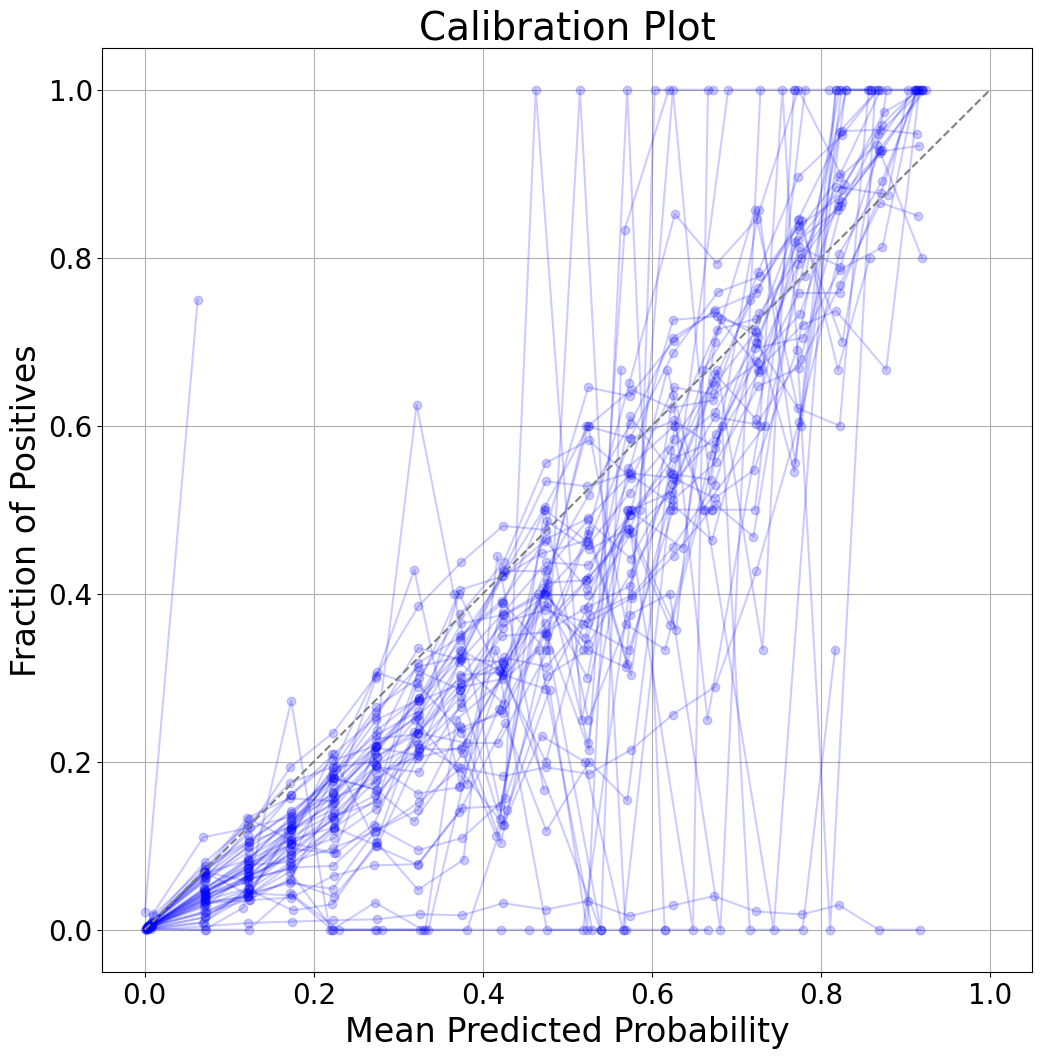

In [5]:
xgb_model_path = './models/XGB_pipeline.joblib'
bs_model_path = './models/baseline_pipeline.joblib'
save_dir = 'S:/PCRC 186 Lou/Sayantan/MPOG_work/Results'

cpt_pred_xgb, cal_cpt_pred_xgb = inst_specific_results(xgb_model_path, cpt_pred = True)
plt.savefig(os.path.join(save_dir,'cal_cpt_pred_xgb.pdf'),bbox_inches='tight', dpi=600)

cpt_pred_xgb.to_csv(os.path.join(save_dir, "cpt_pred_xgb.csv"), index=False)
cal_cpt_pred_xgb.to_csv(os.path.join(save_dir, "cal_cpt_pred_xgb.csv"), index=False)

#### Baseline and hospital-specific priors generated from CPT-PRED 

Total number of institutions selected = 48
Number of cases from 68 = 176384
Number of cases from 68 with not null percent_transfused = 176019
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.02961612098693891
Fraction with mortality == 1 : 0.013215484397677793
Mean base units : 6.023364615919361
Fraction with base units > 7 : 0.13542611574746008
Fraction with ASA Class > 2 : 0.5612527213352685
Fraction with percent_transfused > 1 : 0.3776249546444122
Fraction with QM measure TRAN-01 == Passed : 0.5180548868560424
Fraction with QM measure TRAN-02 == Passed : 0.8846987429562202
AUROC = 0.8941694860610307, AUPRC = 0.34890175874636403, Sensitivity = 0.9597160943794361
--------------------------------

--------------------------------
Number of cases from 83 = 63037
Number of cases from 83 with not null percent_transfused = 62565
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED

Number of cases from 20 with not null percent_transfused = 88544
Medical School Affiliation : ['Yes']
Hospital bed size : ['400-499 beds']
Fraction with NOTHBLEED == 1 : 0.017087549692808096
Fraction with mortality == 1 : 0.021155685590502446
Mean base units : 5.5130099763865825
Fraction with base units > 7 : 0.09215101558543859
Fraction with ASA Class > 2 : 0.727114161931019
Fraction with percent_transfused > 1 : 0.27916502560063017
Fraction with QM measure TRAN-01 == Passed : 0.6042047531992687
Fraction with QM measure TRAN-02 == Passed : 0.9387568555758684
AUROC = 0.8804650048231706, AUPRC = 0.1418130719985182, Sensitivity = 0.9576999339061467
--------------------------------

--------------------------------
Number of cases from 53 = 54460
Number of cases from 53 with not null percent_transfused = 54009
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.029532115017867393
Fraction with mortality == 1 : 0.02065736320235035


Number of cases from 19 = 156923
Number of cases from 19 with not null percent_transfused = 156333
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.020021364651097336
Fraction with mortality == 1 : 0.008558337528596827
Mean base units : 5.509423753269005
Fraction with base units > 7 : 0.09463877188175092
Fraction with ASA Class > 2 : 0.5376649694436124
Fraction with percent_transfused > 1 : 0.3293908477406116
Fraction with QM measure TRAN-01 == Passed : 0.5257214554579673
Fraction with QM measure TRAN-02 == Passed : 0.855081555834379
AUROC = 0.8855462220676156, AUPRC = 0.21875680089671912, Sensitivity = 0.952076677316294
--------------------------------

--------------------------------
Number of cases from 37 = 93068
Number of cases from 37 with not null percent_transfused = 92092
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.042327237979411896
Fraction with m

All percent transfused values == 0 for institution 35
--------------------------------

--------------------------------
Number of cases from 5 = 4425
Number of cases from 5 with not null percent_transfused = 4365
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.0284077892325315
Fraction with mortality == 1 : 0.004293785310734463
Mean base units : 6.456910957269038
Fraction with base units > 7 : 0.17333333333333334
Fraction with ASA Class > 2 : 0.4472316384180791
Fraction with percent_transfused > 1 : 0.36768361581920905
Fraction with QM measure TRAN-01 == Passed : 0.6111111111111112
Fraction with QM measure TRAN-02 == Passed : 0.9722222222222222
AUROC = 0.8865424694419302, AUPRC = 0.25158485269231085, Sensitivity = 0.9435483870967742
--------------------------------

--------------------------------
Number of cases from 48 = 24736
Number of cases from 48 with not null percent_transfused = 20594
Medical School Affiliation : 

AUROC = 0.8431840733704627, AUPRC = 0.32814810107641307, Sensitivity = 0.9555243445692884
--------------------------------

--------------------------------
Number of cases from 82 = 29222
Number of cases from 82 with not null percent_transfused = 28811
Medical School Affiliation : ['No']
Hospital bed size : ['100-199 beds']
Fraction with NOTHBLEED == 1 : 0.0007635972371663601
Fraction with mortality == 1 : 0.001403052494695777
Mean base units : 4.851227219282775
Fraction with base units > 7 : 0.05615632058038464
Fraction with ASA Class > 2 : 0.28468277325302854
Fraction with percent_transfused > 1 : 0.008384094175621108
Fraction with QM measure TRAN-01 == Passed : 0.2
Fraction with QM measure TRAN-02 == Passed : 0.6
AUROC = 0.8685632770092113, AUPRC = 0.004265905313428581, Sensitivity = 0.9545454545454546
--------------------------------

--------------------------------
Number of cases from 38 = 26399
Number of cases from 38 with not null percent_transfused = 26270
Medical School Aff

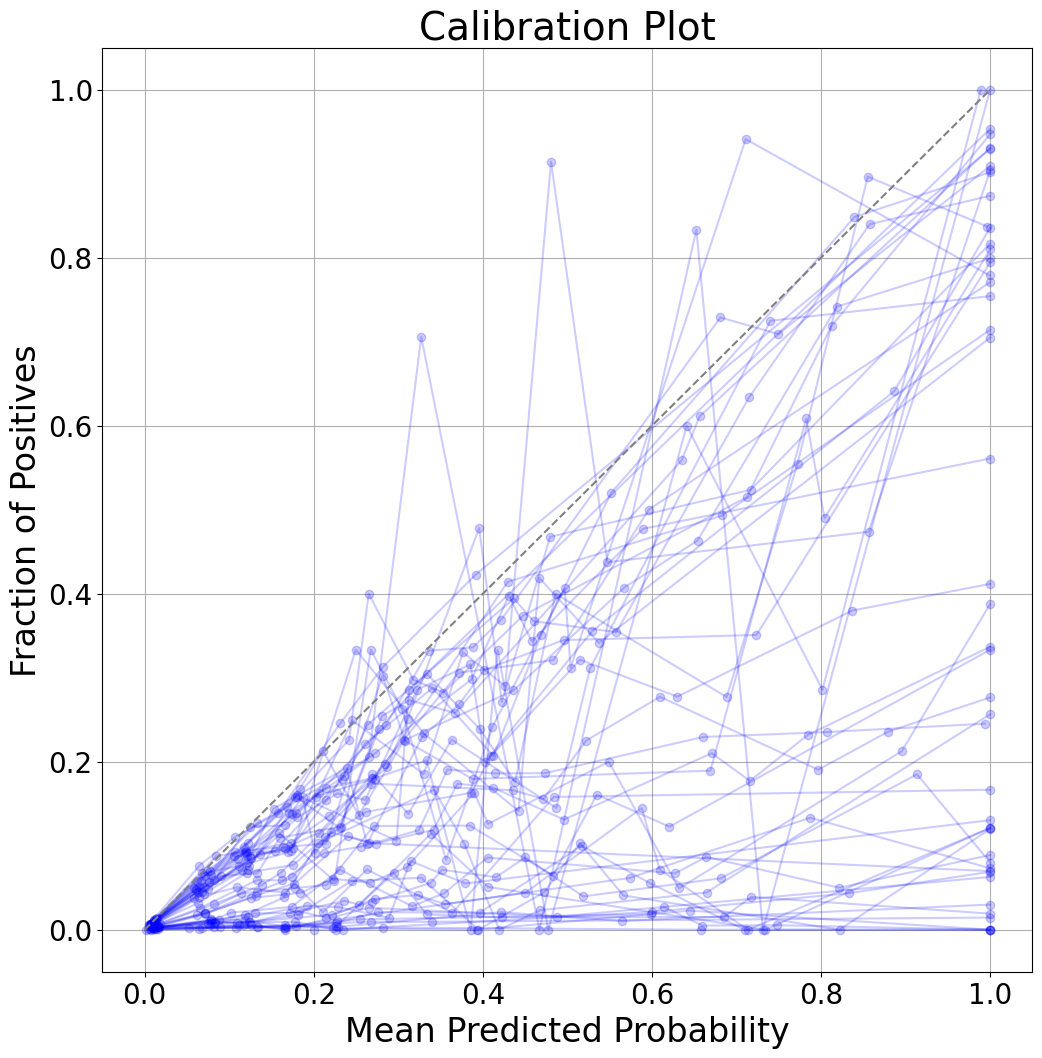

In [6]:
xgb_model_path = './models/XGB_pipeline.joblib'
bs_model_path = './models/baseline_pipeline.joblib'
save_dir = 'S:/PCRC 186 Lou/Sayantan/MPOG_work/Results'

cpt_pred_bs, cal_cpt_pred_bs = inst_specific_results_bs(bs_model_path, cpt_pred = True)
plt.savefig(os.path.join(save_dir,'cal_cpt_pred_bs.pdf'),bbox_inches='tight', dpi=600)

cpt_pred_bs.to_csv(os.path.join(save_dir, "cpt_pred_bs.csv"), index=False)
cal_cpt_pred_bs.to_csv(os.path.join(save_dir, "cal_cpt_pred_bs.csv"), index=False)

#### XgBoost and hospital-specific priors generated from CPT-PRIM

Total number of institutions selected = 48
Number of cases from 68 = 176384
Number of cases from 68 with not null percent_transfused = 174931
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.02941159657236282
Fraction with mortality == 1 : 0.013062409288824383
Mean base units : 6.022670007607854
Fraction with base units > 7 : 0.13480247641509435
Fraction with ASA Class > 2 : 0.558055152394775
Fraction with percent_transfused > 1 : 0.32250090711175616
Fraction with QM measure TRAN-01 == Passed : 0.5223807181505165
Fraction with QM measure TRAN-02 == Passed : 0.8851082633672117
AUROC = 0.9602213273744689, AUPRC = 0.5608713135979808, Sensitivity = 0.959961127308066
--------------------------------

--------------------------------
Number of cases from 83 = 63037
Number of cases from 83 with not null percent_transfused = 60658
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED =

--------------------------------

--------------------------------
Number of cases from 20 = 88865
Number of cases from 20 with not null percent_transfused = 88110
Medical School Affiliation : ['Yes']
Hospital bed size : ['400-499 beds']
Fraction with NOTHBLEED == 1 : 0.01679718533651118
Fraction with mortality == 1 : 0.021043155347999776
Mean base units : 5.508693678356599
Fraction with base units > 7 : 0.09090192989365892
Fraction with ASA Class > 2 : 0.7232318685646768
Fraction with percent_transfused > 1 : 0.24081471895571935
Fraction with QM measure TRAN-01 == Passed : 0.607970342910102
Fraction with QM measure TRAN-02 == Passed : 0.9388322520852641
AUROC = 0.9432773000115433, AUPRC = 0.3226847836168402, Sensitivity = 0.9581081081081081
--------------------------------

--------------------------------
Number of cases from 53 = 54460
Number of cases from 53 with not null percent_transfused = 53438
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fracti

--------------------------------

--------------------------------
Number of cases from 22 = 9083
Number of cases from 22 with not null percent_transfused = 7796
Medical School Affiliation : ['No']
Hospital bed size : ['100-199 beds']
Fraction with NOTHBLEED == 1 : 0.0014109799897383272
Fraction with mortality == 1 : 0.005614884949906419
Mean base units : 4.768173155458753
Fraction with base units > 7 : 0.03104701089948255
Fraction with ASA Class > 2 : 0.4259605857095673
Fraction with percent_transfused > 1 : 0.09292084113178466
Fraction with QM measure TRAN-01 == Passed : 0.5
Fraction with QM measure TRAN-02 == Passed : 1.0
AUROC = 0.7955041746949261, AUPRC = 0.048551946134873805, Sensitivity = 0.7272727272727273
--------------------------------

--------------------------------
Number of cases from 19 = 156923
Number of cases from 19 with not null percent_transfused = 138174
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0

--------------------------------

--------------------------------
Number of cases from 70 = 38806
Number of cases from 70 with not null percent_transfused = 38134
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.036502858341637384
Fraction with mortality == 1 : 0.01628614131835283
Mean base units : 6.021988452107886
Fraction with base units > 7 : 0.17038602277998247
Fraction with ASA Class > 2 : 0.5665361026645365
Fraction with percent_transfused > 1 : 0.45397618924908517
Fraction with QM measure TRAN-01 == Passed : 0.3726273726273726
Fraction with QM measure TRAN-02 == Passed : 0.8491508491508492
AUROC = 0.9290228242663818, AUPRC = 0.39992391429181867, Sensitivity = 0.959051724137931
--------------------------------

--------------------------------
Number of cases from 35 = 87774
Number of cases from 35 with not null percent_transfused = 78747
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
F

Number of cases from 16 = 108768
Number of cases from 16 with not null percent_transfused = 76445
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.07141081823533259
Fraction with mortality == 1 : 0.006794277728743748
Mean base units : 7.68272879242179
Fraction with base units > 7 : 0.20167696381288613
Fraction with ASA Class > 2 : 0.5387981759340983
Fraction with percent_transfused > 1 : 0.3832193292144748
Fraction with QM measure TRAN-01 == Passed : 0.5895715023231802
Fraction with QM measure TRAN-02 == Passed : 0.9148167268972638
AUROC = 0.9274865194438826, AUPRC = 0.5565385831782035, Sensitivity = 0.959516394944129
--------------------------------

--------------------------------
Number of cases from 47 = 55416
Number of cases from 47 with not null percent_transfused = 42692
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.039679565258127984
Fraction with mort

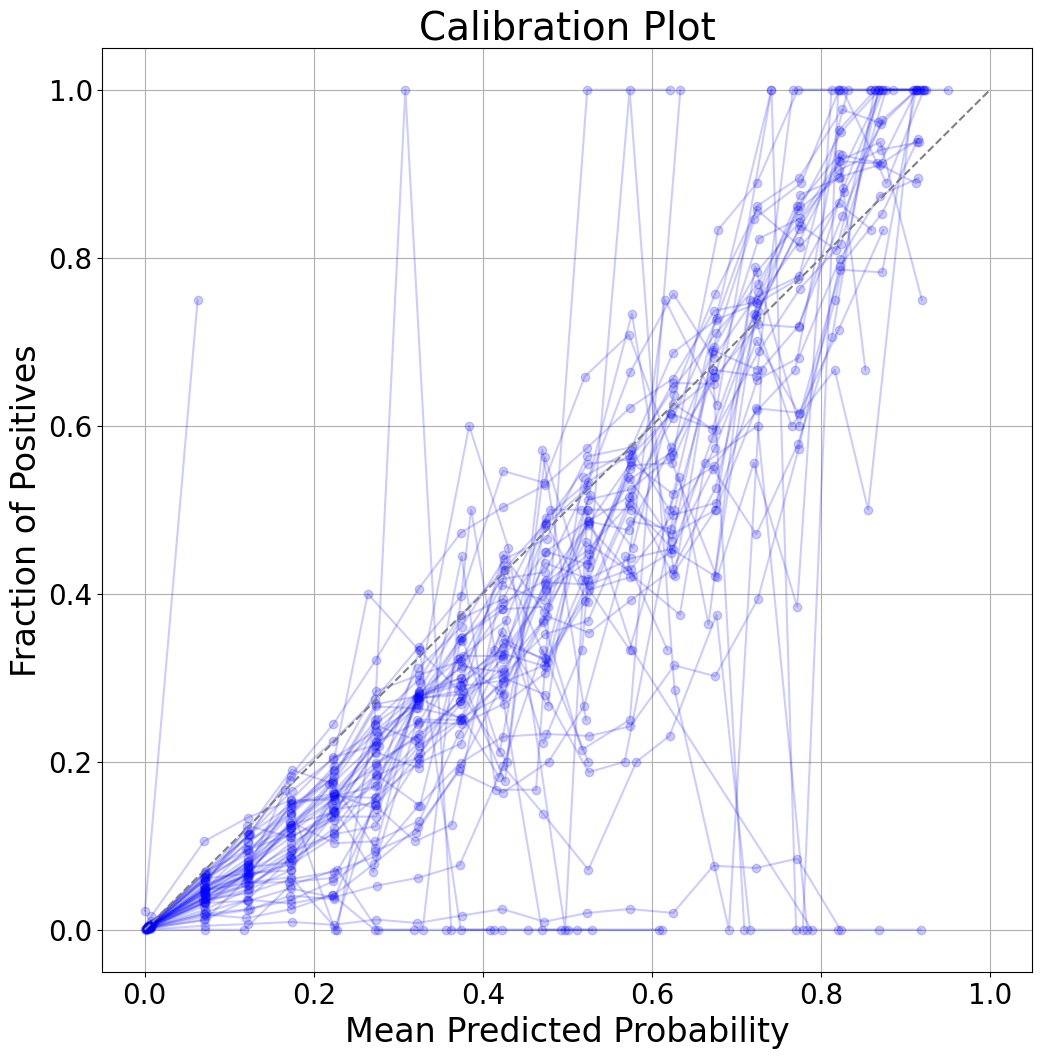

In [7]:
xgb_model_path = './models/XGB_pipeline.joblib'
bs_model_path = './models/baseline_pipeline.joblib'
save_dir = 'S:/PCRC 186 Lou/Sayantan/MPOG_work/Results'

cpt_prim_xgb, cal_cpt_prim_xgb = inst_specific_results(xgb_model_path, cpt_pred = False)
plt.savefig(os.path.join(save_dir,'cal_cpt_prim_xgb.pdf'),bbox_inches='tight', dpi=600)

cpt_prim_xgb.to_csv(os.path.join(save_dir, "cpt_prim_xgb.csv"), index=False)
cal_cpt_prim_xgb.to_csv(os.path.join(save_dir, "cal_cpt_prim_xgb.csv"), index=False)

#### Baseline and hospital-specific priors generated from CPT-PRIM 

Total number of institutions selected = 48
Number of cases from 68 = 176384
Number of cases from 68 with not null percent_transfused = 174931
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.02941159657236282
Fraction with mortality == 1 : 0.013062409288824383
Mean base units : 6.022670007607854
Fraction with base units > 7 : 0.13480247641509435
Fraction with ASA Class > 2 : 0.558055152394775
Fraction with percent_transfused > 1 : 0.32250090711175616
Fraction with QM measure TRAN-01 == Passed : 0.5223807181505165
Fraction with QM measure TRAN-02 == Passed : 0.8851082633672117
AUROC = 0.9155157191702716, AUPRC = 0.42474401910852705, Sensitivity = 0.9593780369290573
--------------------------------

--------------------------------
Number of cases from 83 = 63037
Number of cases from 83 with not null percent_transfused = 60658
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED

Medical School Affiliation : ['Yes']
Hospital bed size : ['400-499 beds']
Fraction with NOTHBLEED == 1 : 0.01679718533651118
Fraction with mortality == 1 : 0.021043155347999776
Mean base units : 5.508693678356599
Fraction with base units > 7 : 0.09090192989365892
Fraction with ASA Class > 2 : 0.7232318685646768
Fraction with percent_transfused > 1 : 0.24081471895571935
Fraction with QM measure TRAN-01 == Passed : 0.607970342910102
Fraction with QM measure TRAN-02 == Passed : 0.9388322520852641
AUROC = 0.9031612776923292, AUPRC = 0.1780575095893497, Sensitivity = 0.9540540540540541
--------------------------------

--------------------------------
Number of cases from 53 = 54460
Number of cases from 53 with not null percent_transfused = 53438
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.027789213668176205
Fraction with mortality == 1 : 0.01986779287550496
Mean base units : 6.2497422067105575
Fraction with base units > 7 :

Number of cases from 19 = 156923
Number of cases from 19 with not null percent_transfused = 138174
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.01927280096110701
Fraction with mortality == 1 : 0.00824608247356984
Mean base units : 5.505821961628493
Fraction with base units > 7 : 0.09404612453241398
Fraction with ASA Class > 2 : 0.47314287899160734
Fraction with percent_transfused > 1 : 0.25668002778432736
Fraction with QM measure TRAN-01 == Passed : 0.5374351371386212
Fraction with QM measure TRAN-02 == Passed : 0.860637509266123
AUROC = 0.8904075302587631, AUPRC = 0.2368670386650284, Sensitivity = 0.9511828764551258
--------------------------------

--------------------------------
Number of cases from 37 = 93068
Number of cases from 37 with not null percent_transfused = 91576
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.04210710229754521
Fraction with mo

All percent transfused values == 0 for institution 35
--------------------------------

--------------------------------
Number of cases from 5 = 4425
Number of cases from 5 with not null percent_transfused = 4359
Medical School Affiliation : ['Yes']
Hospital bed size : ['500 or more beds']
Fraction with NOTHBLEED == 1 : 0.028217481073640742
Fraction with mortality == 1 : 0.004067796610169492
Mean base units : 6.452973229092632
Fraction with base units > 7 : 0.17468926553672318
Fraction with ASA Class > 2 : 0.44451977401129944
Fraction with percent_transfused > 1 : 0.3048587570621469
Fraction with QM measure TRAN-01 == Passed : 0.6
Fraction with QM measure TRAN-02 == Passed : 0.9714285714285714
AUROC = 0.9095873926161357, AUPRC = 0.3072735823553176, Sensitivity = 0.959349593495935
--------------------------------

--------------------------------
Number of cases from 48 = 24736
Number of cases from 48 with not null percent_transfused = 17740
Medical School Affiliation : ['No']
Hospital

AUROC = 0.8842059735917087, AUPRC = 0.39349997483494464, Sensitivity = 0.9563164108618654
--------------------------------

--------------------------------
Number of cases from 82 = 29222
Number of cases from 82 with not null percent_transfused = 27963
Medical School Affiliation : ['No']
Hospital bed size : ['100-199 beds']
Fraction with NOTHBLEED == 1 : 0.0006079462146407753
Fraction with mortality == 1 : 0.0011977277393744438
Mean base units : 4.846691570810371
Fraction with base units > 7 : 0.054650605708028197
Fraction with ASA Class > 2 : 0.27564848401888986
Fraction with percent_transfused > 1 : 0.004551365409622887
Fraction with QM measure TRAN-01 == Passed : 0.25
Fraction with QM measure TRAN-02 == Passed : 0.625
AUROC = 0.8521476292513712, AUPRC = 0.03426750118803161, Sensitivity = 0.8823529411764706
--------------------------------

--------------------------------
Number of cases from 38 = 26399
Number of cases from 38 with not null percent_transfused = 7092
Medical School 

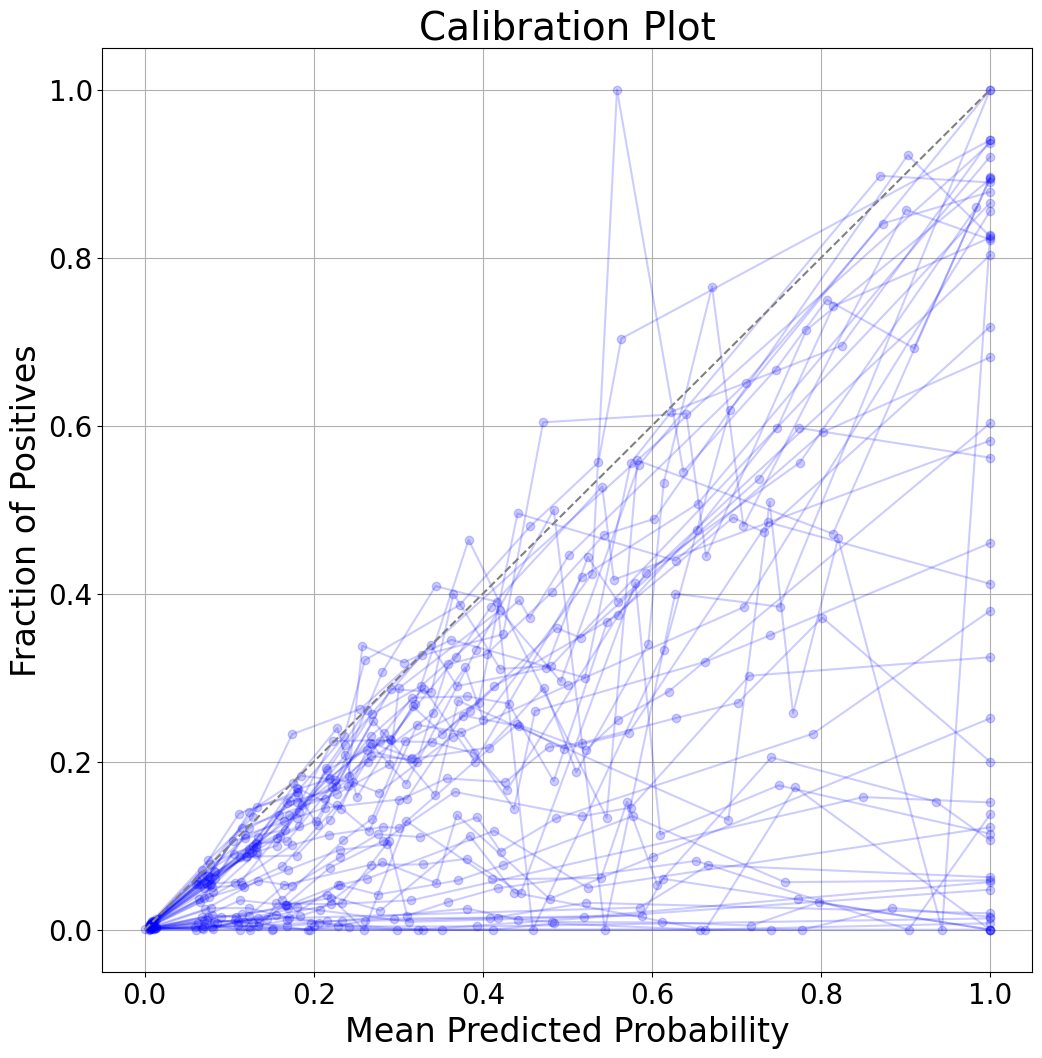

In [8]:
xgb_model_path = './models/XGB_pipeline.joblib'
bs_model_path = './models/baseline_pipeline.joblib'
save_dir = 'S:/PCRC 186 Lou/Sayantan/MPOG_work/Results'

cpt_prim_bs, cal_cpt_prim_bs = inst_specific_results_bs(bs_model_path, cpt_pred = False)
plt.savefig(os.path.join(save_dir,'cal_cpt_prim_bs.pdf'),bbox_inches='tight', dpi=600)

cpt_prim_bs.to_csv(os.path.join(save_dir, "cpt_prim_bs.csv"), index=False)
cal_cpt_prim_bs.to_csv(os.path.join(save_dir, "cal_cpt_prim_bs.csv"), index=False)

## Performance analysis stratified by race

And I do think that we should probably look at AUROC, sensitivity, and percent positive by race group. How about you do that for the 5 largest institutions in caseinfo2? i.e., look at AUROC stratified by race, then use whatever decision threshold was set for the overall population at that institution and measure sensitivity and percent positive stratified by race group. Let me know if you have questions about this.

#### AUROC, AUROC, sensitivity and PPV stratified across race within each institution

In [8]:
# So, let's say the 5 largest institutions are 1,2,3,4,5.
# Step 1: So, I pick 1 and calculate the AUROC/AUPRC for each race category within 1. 
# Step 2: Next, I calculate the best threshold from 1's predictions. 
# Step 3: Next , I calculate the sensitivity and percent positive for each of the 10 race categories within 1 and the threshold used will be the best threshold calculated in the previous step. 
# Step 4: Repeat steps 1-3 for institutions 2,3,4,5.

#-----------------------------------------------
# 5 largest institutions in Case 2 [69,  57,  68,  84,  19]

# test_data = pd.read_csv('c2_pred_match.csv').dropna(subset = ['NOTHBLEED']).reset_index(drop = True)
# test_data = load_MPOG_test_data(test_data)
# assert test_data.CaseID.nunique() == len(test_data)

race_allinst_perf = []
metric_list = ['institution', 'auroc', 'auprc', 'sensitivity', 'specificity', 'PPV', 'NPV', 'frac_pos', 'best_threshold', 'num_cases', 'nonzero_per_tf']

#inst_list = test_data.Institution.unique()
inst_list = [69,  57,  68,  84,  19]
for inst_name in inst_list:
    
    print(inst_name)

    inst_test_data = test_data.loc[test_data.Institution == inst_name].dropna(subset = 'percent_transfused').reset_index(drop = True)

    ## Run model across entire population within the institution to get the best threshold

    data_pipeline, X_test, y_test, feat_used = load_model_pipeline(xgb_model_path, inst_test_data)
    y_prob = data_pipeline.model.predict_proba(X_test)[:, 1]

    def line_search_best_metric(y_test, y_prob, sens_thresh=0.96):
        for t in np.arange(0.0, 1.0, 0.0001):
            sens, spec, PPV, NPV, acc = metric_eval(y_test, y_prob > t)
            if sens < sens_thresh:
                #return (sens, spec, PPV, NPV, acc), t
                return t

    best_threshold_inst = line_search_best_metric(y_test, y_prob)

    #--------------------------------------------------------------
    auroc_allrace = {}
    auprc_allrace = {}
    sens_allrace = {}
    spec_allrace = {} 
    PPV_allrace = {} 
    NPV_allrace = {} 
    acc_allrace = {}

    race_list = list(inst_test_data.Race.value_counts().sort_values().index.values)
    for race_cat in race_list:

        #print(race_cat)

        race_inst_data = inst_test_data.loc[inst_test_data.Race == race_cat].dropna(subset = 'percent_transfused').reset_index(drop = True)
        data_pipeline_race, X_test_race, y_test_race, feat_used_race = load_model_pipeline(xgb_model_path, race_inst_data)

        save_path = 'S:\PCRC 186 Lou\Sayantan\MPOG_work'
        y_prob_race = data_pipeline_race.model.predict_proba(X_test_race)[:, 1]

        # Evaluation
        fpr, tpr, _ = metrics.roc_curve(y_test_race, y_prob_race)
        prec, rec, _ = metrics.precision_recall_curve(y_test_race, y_prob_race)

        sens, spec, PPV, NPV, acc = metric_eval(y_test, y_prob > best_threshold_inst)

        sens_allrace[race_cat] = sens
        spec_allrace[race_cat] = spec
        PPV_allrace[race_cat] = PPV
        NPV_allrace[race_cat] = NPV
        acc_allrace[race_cat] = acc

        y_pred = y_prob > best_threshold_inst

        auroc = metrics.auc(fpr, tpr)
        auprc = metrics.auc(rec, prec)

        auroc_allrace[race_cat] = auroc
        auprc_allrace[race_cat] = auprc

    metric_dict_list = [auroc_allrace, auprc_allrace, sens_allrace, spec_allrace, PPV_allrace, NPV_allrace, acc_allrace]
    metric_list = ['auroc', 'auprc', 'sens', 'spec', 'PPV', 'NPV', 'acc']

    race_inst_perf = pd.DataFrame(metric_dict_list, index=metric_list).T.reset_index().rename(columns = {'index':'Race'})
    race_inst_perf['Institution'] = inst_name
    
    race_allinst_perf.append(race_inst_perf)

save_dir = 'S:/PCRC 186 Lou/Sayantan/MPOG_work/Results'
race_allinst_perf_df = pd.DataFrame()

for df in race_allinst_perf:
    race_allinst_perf_df = pd.concat([race_allinst_perf_df, df], ignore_index=True)

race_allinst_perf_df.to_csv(os.path.join(save_dir, "race_allinst_perf_df.csv"), index=False)
race_allinst_perf_df

69
57
68
84
19


,Race,auroc,auprc,sens,spec,PPV,NPV,acc,Institution
0,Hispanic black,NaN,NaN,0.958754,0.750955,0.047272,0.999293,0.258076,69
1,American Indian or Alaska Native,0.994643,0.125000,0.958754,0.750955,0.047272,0.999293,0.258076,69
2,Hispanic white,0.973013,0.085455,0.958754,0.750955,0.047272,0.999293,0.258076,69
3,Asian or Pacific Islander,0.922889,0.294879,0.958754,0.750955,0.047272,0.999293,0.258076,69
4,Black not of hispanic origin,0.933719,0.263061,0.958754,0.750955,0.047272,0.999293,0.258076,69
5,Unknown race,0.946878,0.328211,0.958754,0.750955,0.047272,0.999293,0.258076,69
6,White not of hispanic origin,0.949419,0.275297,0.958754,0.750955,0.047272,0.999293,0.258076,69
7,Hispanic black,0.979503,0.789221,0.959902,0.744388,0.110912,0.998214,0.278255,57
8,American Indian or Alaska Native,0.975623,0.752717,0.959902,0.744388,0.110912,0.998214,0.278255,57
9,Unknown race,0.881894,0.422643,0.959902,0.744388,0.110912,0.998214,0.278255,57


#### Calibration plot stratified by race (Note this is across institutions)

I was thinking more about the race analysis. I think the easiest thing to do would be to look at 
calibration stratified by race. Perhaps you can take the whole caseinfo2 cohort, split it by the 
different race categories, and plot the calibration for each group onto one plot?
I feel like this analysis would be relatively more independent of patient complexity.

Number of cases from Middle Eastern = 142
Number of cases from Middle Eastern with not null percent_transfused = 139
AUROC = 0.9518518518518518, AUPRC = 0.592156862745098, Sensitivity = 0.5
--------------------------------

--------------------------------
Number of cases from Hispanic black = 6384
Number of cases from Hispanic black with not null percent_transfused = 6293
AUROC = 0.9464288835290828, AUPRC = 0.457130121818587, Sensitivity = 0.959731543624161
--------------------------------

--------------------------------
Number of cases from American Indian or Alaska Native = 17458
Number of cases from American Indian or Alaska Native with not null percent_transfused = 16813
AUROC = 0.8778855062905488, AUPRC = 0.3959690850688337, Sensitivity = 0.959349593495935
--------------------------------

--------------------------------
Number of cases from Bi or Multi Racial = 18952
Number of cases from Bi or Multi Racial with not null percent_transfused = 18620
AUROC = 0.9274143668725512, A

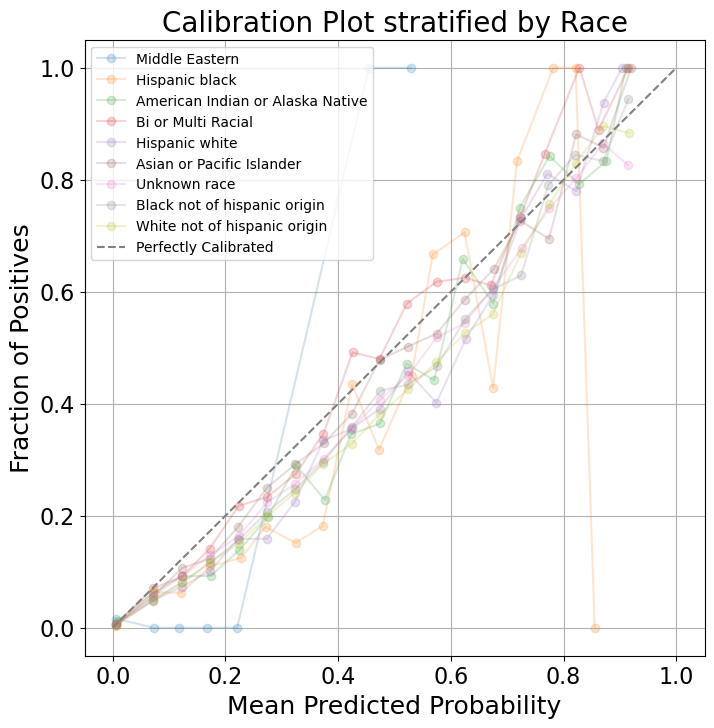

In [7]:
test_data = pd.read_csv('c2_pred_match.csv').dropna(subset = ['NOTHBLEED']).reset_index(drop = True)
test_data = load_MPOG_test_data(test_data)
assert test_data.CaseID.nunique() == len(test_data)

bad_inst_list = [67, 118, 92, 101, 91, 115, 102, 99, 13, 98]
test_data = test_data.loc[~test_data.Institution.isin(bad_inst_list)].reset_index(drop = True)

xgb_model_path = './models/XGB_pipeline.joblib'
root_dir = 'S:\PCRC 186 Lou\Sayantan\MPOG_work'

metric_list = ['institution', 'auroc', 'auprc', 'sensitivity', 'specificity', 'PPV', 'NPV', 'frac_pos', 'best_threshold', 'num_cases', 'nonzero_per_tf']
cal_results = pd.DataFrame(columns = ['Institution', 'Bin', 'pred_true', 'pred_prob'])

allrace_cal_results = []

race_data_dict = {}
race_list = list(test_data.Race.value_counts().sort_values().index.values)

plt.figure(figsize = (8,8))
for name in race_list:

    race_test_data = test_data.loc[test_data.Race == name].reset_index(drop = True)
    num_cases = len(race_test_data)
    print('Number of cases from {} = {}'.format(name, len(race_test_data)))

    race_test_data = race_test_data.dropna(subset = 'percent_transfused').reset_index(drop = True)
    nonnull_pt = len(race_test_data)
    print('Number of cases from {} with not null percent_transfused = {}'.format(name, nonnull_pt))
    
    if nonnull_pt == 0:
        null_pt_list.append(name)
        print('No non-null values for race {}'.format(name))
        print('--------------------------------\n')
        print('--------------------------------')
        continue
        
    
    race_data_dict[name] = race_test_data

    data_pipeline, X_test, y_test, feat_used = load_model_pipeline(xgb_model_path, race_test_data)
        
    save_path = 'S:\PCRC 186 Lou\Sayantan\MPOG_work'
    auroc, auprc, sensitivity, specificity, PPV, NPV, frac_pos, best_threshold = evaluate_model(data_pipeline.model, X_test, y_test, save_path, plot = False)
    print('AUROC = {}, AUPRC = {}, Sensitivity = {}'.format(auroc, auprc, sensitivity))

    print('--------------------------------\n')
    print('--------------------------------')
    
    ############# Plot the calibration curve ############
    #print(name)
    y_pred_prob = data_pipeline.model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=20)
        
    race_cal_results = pd.DataFrame({'Bin ID': np.arange(len(prob_true)),
                                     'True Probability': prob_true, 
                                     'Predicted Probability': prob_pred})
    race_cal_results['Race'] = name
    allrace_cal_results.append(race_cal_results)

        
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label = name, alpha = 0.2)

cal_results = pd.concat(allrace_cal_results, ignore_index=True)
    
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
#plt.legend(fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Mean Predicted Probability', fontsize = 18)
plt.ylabel('Fraction of Positives', fontsize = 18)
plt.title('Calibration Plot stratified by Race'.format(name), fontsize = 20)
plt.grid(True)
plt.legend()
#plt.tight_layout()
#plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
save_dir = 'S:/PCRC 186 Lou/Sayantan/MPOG_work/Results'    
plt.savefig(os.path.join(save_dir,'calibration_race_xgb.pdf'),bbox_inches='tight', dpi=600)
            

### Compare performance between institution-specfic and surgeon-specific prior

Identify the cases with both surgeon-specific and institution-specific priors 

In [12]:
def filter_both_inst_surg(model_path):
    
    inst_cpt = pd.read_csv('c2_pred_match.csv').dropna(subset = ['NOTHBLEED']).reset_index(drop = True)
    
#     if cpt_pred == True:
#         inst_cpt = pd.read_csv('c2_pred_match.csv').dropna(subset = ['NOTHBLEED']).reset_index(drop = True)
#     else:
#         inst_cpt = pd.read_csv('c2_match.csv').dropna(subset = ['NOTHBLEED']).reset_index(drop = True)

    inst_cpt = load_MPOG_test_data(inst_cpt).dropna(subset = ['percent_transfused']).reset_index(drop = True)
    assert inst_cpt.percent_transfused.isnull().sum() == 0
    assert inst_cpt.CaseID.nunique() == len(inst_cpt)

    bad_inst_list = [67, 118, 92, 101, 91, 115, 102, 99, 13, 98]
    inst_cpt = inst_cpt.loc[~inst_cpt.Institution.isin(bad_inst_list)].reset_index(drop = True)
    #print('Number of cases in inst_cpt = {}'.format(len(inst_cpt)))

    # #--------------------------

    surg_cpt = pd.read_csv('c2_pred_match_surg.csv').dropna(subset = ['NOTHBLEED']).reset_index(drop = True)
    surg_cpt = load_MPOG_test_data(surg_cpt).dropna(subset = ['percent_transfused']).reset_index(drop = True)
    assert surg_cpt.percent_transfused.isnull().sum() == 0

    bad_inst_list = [67, 118, 92, 101, 91, 115, 102, 99, 13, 98]
    surg_cpt = surg_cpt.loc[~surg_cpt.Institution.isin(bad_inst_list)].reset_index(drop = True)
    #print('Number of cases in surg_cpt = {}'.format(len(surg_cpt)))

    #--------- Filter cases with both surgeon-specific priors and institution-specific priors------
    filtered_surg_cpt = surg_cpt[surg_cpt['CaseID'].isin(inst_cpt['CaseID'])]
    filtered_inst_cpt = inst_cpt[inst_cpt['CaseID'].isin(surg_cpt['CaseID'])]

    # print(filtered_surg_cpt.CaseID.nunique())
    # print(filtered_inst_cpt.CaseID.nunique())
    assert filtered_surg_cpt.CaseID.nunique() == filtered_inst_cpt.CaseID.nunique()
    
    return filtered_inst_cpt, filtered_surg_cpt

#############################################

def xgb_validation(inst_cpt):
    model_path = './models/XGB_pipeline.joblib'
    data_pipeline, X_test, y_test, feat_used = load_model_pipeline(model_path, inst_cpt)

    save_path = 'S:\PCRC 186 Lou\Code\Sayantan Codes'
    auroc, auprc, sensitivity, specificity, PPV, NPV, frac_pos, best_threshold = evaluate_model(data_pipeline.model, X_test, y_test, save_path, plot = False)

    col_list = ['auroc', 'auprc', 'sensitivity', 'specificity', 'PPV', 'NPV', 'frac_pos', 'best_threshold']
    val_list = [auroc, auprc, sensitivity, specificity, PPV, NPV, frac_pos, best_threshold]
    stats_df = pd.DataFrame([val_list], columns = col_list)
    
    return stats_df



In [16]:
# Case 1: Inst-prior and XGB
# Case 2: Inst-prior and baseline
# Case 3: Surg-prior and XGB
# Case 4: Surg-prior and baseline

save_dir = 'S:/PCRC 186 Lou/Sayantan/MPOG_work/Results'
xgb_model_path = './models/XGB_pipeline.joblib'
bs_model_path = './models/baseline_pipeline.joblib'

filtered_inst_cpt_xgb, filtered_surg_cpt_xgb = filter_both_inst_surg(xgb_model_path)
filtered_inst_cpt_bs, filtered_surg_cpt_bs = filter_both_inst_surg(bs_model_path)

stats_inst_xgb = xgb_validation(filtered_inst_cpt_xgb)
stats_inst_xgb['prior'] = 'inst'
stats_inst_xgb['model'] = 'xgb'
print('Case 1 completed')

stats_inst_bs = xgb_validation(filtered_inst_cpt_bs)
stats_inst_bs['prior'] = 'inst'
stats_inst_bs['model'] = 'baseline'
print('Case 2 completed')

stats_surg_xgb = xgb_validation(filtered_surg_cpt_xgb)
stats_surg_xgb['prior'] = 'surg'
stats_surg_xgb['model'] = 'xgb'
print('Case 3 completed')

stats_surg_bs = xgb_validation(filtered_surg_cpt_bs)
stats_surg_bs['prior'] = 'surg'
stats_surg_bs['model'] = 'baseline'
print('Case 4 completed')

combined_df_stats = pd.concat([stats_inst_xgb, stats_inst_bs, stats_surg_xgb, stats_surg_bs]).reset_index(drop=True, inplace=False)
combined_df_stats.to_csv(os.path.join(save_dir, "combined_df_stats.csv"), index=False)

combined_df_stats

Number of cases in inst_cpt = 3487843
Number of cases in surg_cpt = 1508347
Number of cases in inst_cpt = 3487843
Number of cases in surg_cpt = 1508347
Case 1 completed
Case 2 completed
Case 3 completed
Case 4 completed


,auroc,auprc,sensitivity,specificity,PPV,NPV,frac_pos,best_threshold,prior,model
0,0.943211,0.388812,0.959443,0.739750,0.070551,0.998872,0.274356,0.0108,inst,xgb
1,0.943211,0.388812,0.959443,0.739750,0.070551,0.998872,0.274356,0.0108,inst,baseline
2,0.946113,0.423562,0.959886,0.730704,0.071802,0.998810,0.283965,0.0054,surg,xgb
3,0.946113,0.423562,0.959886,0.730704,0.071802,0.998810,0.283965,0.0054,surg,baseline
